# **Machine Learning Essentials // Summer Semester 2024 // Exercise 01**

## Team-Member
### 1. Sushmitha Chandrakumar - 4732591
### 2. Nils-Frederik Schulze - 4240970
### 3. Colin Fredynand - 4730221

# **1 Exploring the Data**

In [5]:
import numpy as np
from sklearn . datasets import load_digits
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import model_selection

In [6]:
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [7]:
index = list(np.argwhere(target == 3))

In [8]:
img = data[index[0]].reshape((8,8))
assert 2 == len(img.shape)

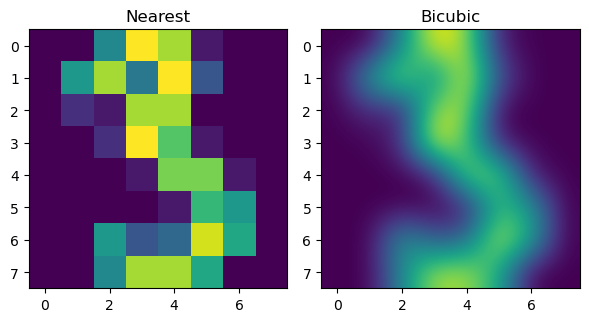

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axes[0].imshow(img, interpolation = "nearest")
axes[1].imshow(img, interpolation = "bicubic")
fig.tight_layout()
axes[0].title.set_text('Nearest')
axes[1].title.set_text('Bicubic')
plt.show()

In [10]:
X_all = data
y_all = target
filtered_indices = (target == 3) | (target == 9)
data_filtered = data[filtered_indices]
target_filtered = target[filtered_indices]
target_filtered_adjusted = np.where(target_filtered == 3, -1, 1)

print(data_filtered.shape)
print(target_filtered.shape)
print(target_filtered_adjusted.shape)


(363, 64)
(363,)
(363,)


In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data_filtered, target_filtered, test_size=0.4, random_state=0
)
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 217
Test set size: 146


# **2 Hand-crafted classifer**
## **2.1 Feature construction**

In [13]:
from scipy.stats import ttest_ind

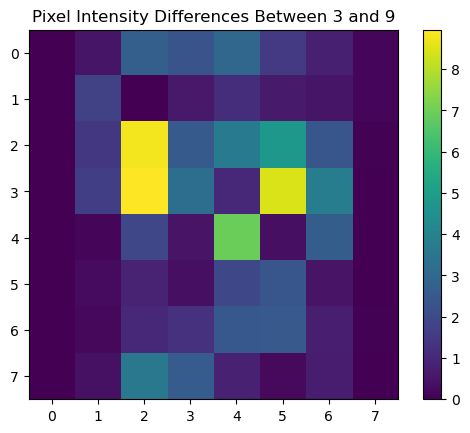

The most two important indices: [29 26]


In [14]:
# Compute average images
avg_3 = np.mean(data_filtered[target_filtered == 3], axis=0)
avg_9 = np.mean(data_filtered[target_filtered == 9], axis=0)

# Compute the difference image
diff_image = np.abs(avg_3 - avg_9)

# Visualize the difference
plt.imshow(diff_image.reshape(8, 8), cmap='viridis', interpolation='nearest')
plt.title('Pixel Intensity Differences Between 3 and 9')
plt.colorbar()
plt.show()

# Perform t-tests on each pixel
p_values = [ttest_ind(data_filtered[target_filtered == 3][:, i], data_filtered[target_filtered == 9][:, i]).pvalue for i in range(data_filtered.shape[1])]

# Select two pixels with the lowest p-values (most significant difference)
important_indices = np.argsort(p_values)[:2]

print(f"The most two important indices: {important_indices}")

In [15]:
def features2d(x):
    return np.column_stack((x[:, important_indices[0]], x[:, important_indices[1]])) + 1

features = features2d(data_filtered)

features[:5]


array([[ 2.,  3.],
       [16., 17.],
       [ 3.,  1.],
       [12.,  2.],
       [13.,  1.]])

## **2.2 Scatterplot**

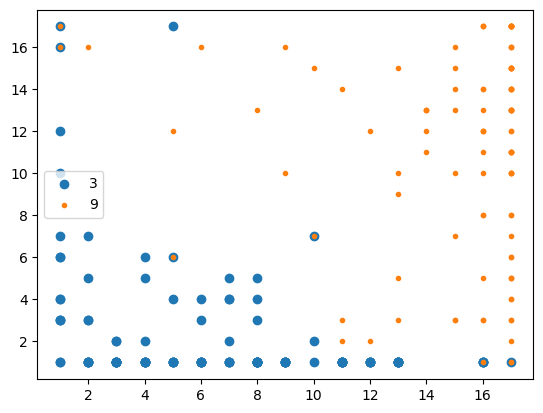

In [17]:
# Generate features
X_train_features = features2d(X_train)
X_test_features = features2d(X_test)

# Scatterplot the data
plt.figure()
plt.scatter(X_train_features[y_train == 3, 0], X_train_features[y_train == 3, 1], marker='o')
plt.scatter(X_train_features[y_train == 9, 0], X_train_features[y_train == 9, 1], marker='.')
plt.legend(["3", "9"])
plt.show()

## **2.3 Decision rule**

In [19]:
import numpy as np

def nearest_mean(training_features, training_labels, test_features):
    unique_labels = np.unique(training_labels)
    means = {label: np.mean(training_features[training_labels == label], axis=0) for label in unique_labels}
    predicted_labels = []
    for feature in test_features:
        nearest_label = min(means, key=lambda label: np.linalg.norm(feature - means[label]))
        predicted_labels.append(nearest_label)
    return np.array(predicted_labels)

# Convert labels to -1 for '3' and 1 for '9'
y_train_adjusted = np.where(y_train == 3, -1, 1)
y_test_adjusted = np.where(y_test == 3, -1, 1)


# Calculate the predicted labels for training and test sets
y_train_pred = nearest_mean(X_train_features, y_train_adjusted, X_train_features)
y_test_pred = nearest_mean(X_train_features, y_train_adjusted, X_test_features)

# Function to calculate classification error
def classification_error(y_true, y_pred):
    return np.mean(y_true != y_pred)

# Print the errors
print("Training Error:", classification_error(y_train_adjusted, y_train_pred))
print("Test Error:", classification_error(y_test_adjusted, y_test_pred))


Training Error: 0.055299539170506916
Test Error: 0.06164383561643835


## 2.4 Visualize the decision reagions

In [21]:
def plot_decision_boundary(X, y, means, resolution=200):
    # Set up the grid
    grid_x, grid_y = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, resolution),
                                 np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, resolution))
    grid = np.c_[grid_x.ravel(), grid_y.ravel()]

    # Predict grid labels
    grid_labels = nearest_mean(means, [1, -1], grid)

    # Reshape for visualization
    grid_labels = grid_labels.reshape(grid_x.shape)

    # Plot
    plt.contourf(grid_x, grid_y, grid_labels, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=100)  # Plot means
    plt.title('Decision Regions')
    plt.show()

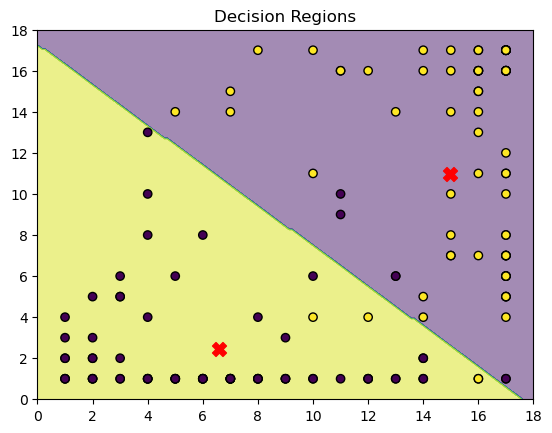

In [22]:
# Calculate means for plotting
class_means = np.array([np.mean(X_train_features[y_train == 3], axis=0),
                        np.mean(X_train_features[y_train == 9], axis=0)])

plot_decision_boundary(X_test_features, y_test_adjusted, class_means)

# 3 LDA

## 3.1 Implement LDA training

In [25]:
def fit_lda(training_features, training_labels):
    # Identify classes
    classes = np.unique(training_labels)
    
    # Initialize means and compute priors
    mu = np.array([np.mean(training_features[training_labels == cls], axis=0) for cls in classes])
    p = np.array([np.sum(training_labels == cls) / len(training_labels) for cls in classes])
    
    # Compute overall covariance matrix
    covmat = np.zeros((training_features.shape[1], training_features.shape[1]))
    for cls in classes:
        class_samples = training_features[training_labels == cls]
        mean_vec = mu[classes == cls][0]
        covmat += np.dot((class_samples - mean_vec).T, (class_samples - mean_vec))
    
    covmat /= len(training_features)
    
    return mu, covmat, p

training_features = features2d(X_train)
training_labels = correct_labels(y_train)
mu, covmat, p = fit_lda(training_features, training_labels)

In [27]:
def filter_dead_pixels(data):
    variances = np.var(data, axis=0)
    return data[:, variances > 0.001]

## 3.2 Implement LDA prediction

In [29]:
def predict_lda(mu, covmat, p, test_features):
    # Regularize the covariance matrix
    regularization_term = 0.01 * np.eye(covmat.shape[0])  # Small value added to the diagonal
    regularized_covmat = covmat + regularization_term
    
    # Use inverse of the regularized covariance matrix
    inv_covmat = np.linalg.inv(regularized_covmat)
    
    beta = np.dot(inv_covmat, (mu[1] - mu[0]))
    b = -0.5 * np.dot((mu[1] + mu[0]), beta) + np.log(p[1] / p[0])
    
    logits = np.dot(test_features, beta) + b
    return np.sign(logits)

In [30]:
mu, covmat, p = fit_lda(X_train, y_train)

# Predict and compute errors
train_preds = predict_lda(mu, covmat, p, X_train)
test_preds = predict_lda(mu, covmat, p, X_test)

train_error = np.mean(train_preds != y_train_adjusted)
test_error = np.mean(test_preds != y_test_adjusted)

print("Errors with full pixel vector")
print("Training Error:", train_error)
print("Test Error:", test_error)

Errors with full pixel vector
Training Error: 0.004608294930875576
Test Error: 0.0136986301369863


In [31]:
mu, covmat, p = fit_lda(X_train_features, y_train)

# Predict and compute errors
train_preds = predict_lda(mu, covmat, p, X_train_features)
test_preds = predict_lda(mu, covmat, p, X_test_features)

train_error = np.mean(train_preds != y_train_adjusted)
test_error = np.mean(test_preds != y_test_adjusted)

print("Errors with 2d feature vector")
print("Training Error:", train_error)
print("Test Error:", test_error)


Errors with 2d feature vector
Training Error: 0.055299539170506916
Test Error: 0.06164383561643835


## 3.3 Visualization

In [33]:
from matplotlib.patches import Ellipse

def plot_decision_regions(X, y, mu, covmat, title="LDA Decision Regions"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = predict_lda(mu, covmat, p, grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='hot')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='hot', edgecolor='k', s=50)

    eigenvalues, eigenvectors = np.linalg.eig(covmat)
    for mean in mu:
        for axis in range(len(eigenvalues)):
            eigenvalue = eigenvalues[axis]
            eigenvector = eigenvectors[:, axis]
            # Calculate angle of the eigenvector
            angle = np.degrees(np.arctan2(eigenvector[1], eigenvector[0]))
            # Eigenvalue is the variance along this eigenvector
            std_dev = np.sqrt(eigenvalue)
            ell_width, ell_height = 2 * std_dev, 2 * std_dev  # Width and height are scaled by std deviation
            ellipse = Ellipse(xy=mean, width=ell_width, height=ell_height, angle=angle,
                              edgecolor='black', facecolor='none', lw=2)
            plt.gca().add_patch(ellipse)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

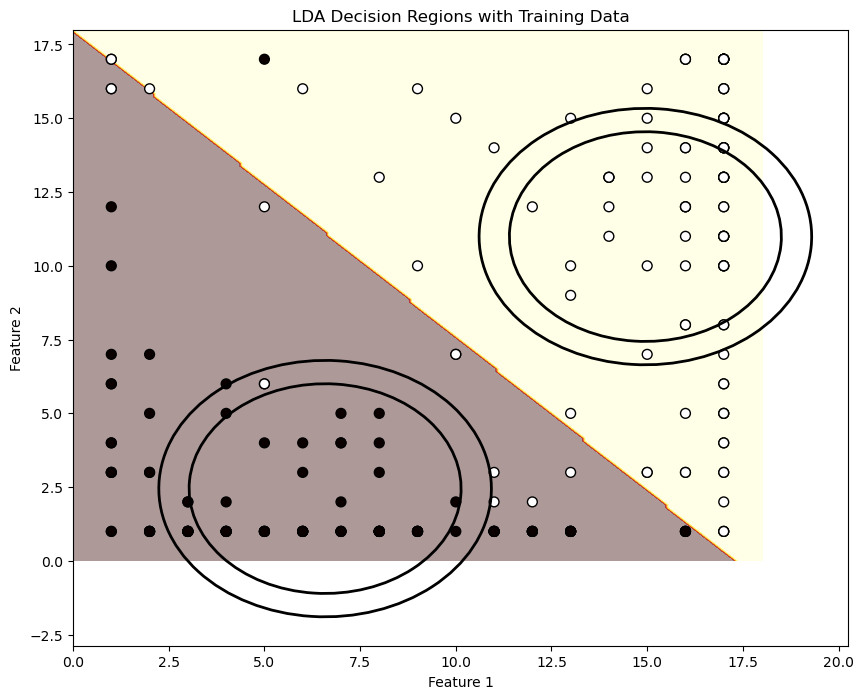

In [34]:
plot_decision_regions(X_train_features, y_train_adjusted, mu, covmat, "LDA Decision Regions with Training Data")

## 3.4 Quantitative performance evaluation

In [36]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomLDA(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.mu_ = None
        self.covmat_ = None
        self.priors_ = None
    
    def fit(self, X, y):
        self.mu_, self.covmat_, self.priors_ = fit_lda(X, y)
        return self
    
    def predict(self, X):
        return predict_lda(self.mu_, self.covmat_, self.priors_, X)

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SklearnLDA

# Initialize classifiers
custom_lda = CustomLDA()
sklearn_lda = SklearnLDA()

In [38]:
# Perform cross-validation
scores_custom = cross_val_score(custom_lda, features2d(data_filtered), target_filtered_adjusted, cv=10)
scores_sklearn = cross_val_score(sklearn_lda, features2d(data_filtered), target_filtered_adjusted, cv=10)

print("CV with full pixel vector")
print("Custom LDA 10-Fold CV Scores:", scores_custom)
print("Average CV Score (Custom LDA):", np.mean(scores_custom))
print("Sklearn LDA 10-Fold CV Scores:", scores_sklearn)
print("Average CV Score (Sklearn LDA):", np.mean(scores_sklearn))

CV with full pixel vector
Custom LDA 10-Fold CV Scores: [0.81081081 0.94594595 0.97297297 0.97222222 1.         0.94444444
 0.97222222 0.97222222 0.77777778 0.88888889]
Average CV Score (Custom LDA): 0.9257507507507509
Sklearn LDA 10-Fold CV Scores: [0.81081081 0.94594595 0.97297297 0.97222222 1.         0.94444444
 0.97222222 0.97222222 0.77777778 0.88888889]
Average CV Score (Sklearn LDA): 0.9257507507507509


In [39]:
# Perform cross-validation
scores_custom = cross_val_score(custom_lda, data_filtered, target_filtered_adjusted, cv=10)
scores_sklearn = cross_val_score(sklearn_lda, data_filtered, target_filtered_adjusted, cv=10)

print("CV with 2d feature vector")
print("Custom LDA 10-Fold CV Scores:", scores_custom)
print("Average CV Score (Custom LDA):", np.mean(scores_custom))
print("Sklearn LDA 10-Fold CV Scores:", scores_sklearn)
print("Average CV Score (Sklearn LDA):", np.mean(scores_sklearn))

CV with 2d feature vector
Custom LDA 10-Fold CV Scores: [0.97297297 1.         0.97297297 0.94444444 0.97222222 1.
 1.         1.         1.         0.91666667]
Average CV Score (Custom LDA): 0.9779279279279278
Sklearn LDA 10-Fold CV Scores: [0.97297297 1.         0.97297297 0.94444444 0.97222222 1.
 1.         1.         1.         0.91666667]
Average CV Score (Sklearn LDA): 0.9779279279279278


# 4 SVM

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn import svm

In [42]:
def relu(x):
    return np.maximum(0, x)

In [43]:
def fit_svm(X, y, lambda_val=0.01, lr=0.1, epochs=1000):
    N, D = X.shape  # Number of samples and number of features
    beta = np.random.normal(0, 1, D)  # Initial guess for beta
    b = 0  # Initial guess for bias

    for epoch in range(epochs):
        margins = y * (np.dot(X, beta) + b)
        loss = 0.5 * np.dot(beta, beta) + (lambda_val / N) * np.sum(relu(1 - margins))
        misclassified = margins < 1
        d_beta = beta + (lambda_val / N) * np.dot(X[misclassified].T, -y[misclassified])
        d_b = (lambda_val / N) * np.sum(-y[misclassified])

        beta -= lr * d_beta
        b -= lr * d_b
        
        # Learning rate schedule
        if epoch % 100 == 0:
            lr /= 10

    return beta, b

In [44]:
beta, b = fit_svm(data_filtered, target_filtered_adjusted)

In [45]:
def predict_svm(beta, b, X):
    return np.sign(np.dot(X, beta) + b)

In [46]:
class CustomSVM(BaseEstimator):
    def __init__(self, lambda_val=0.01, lr=0.01, epochs=1000):
        self.lambda_val = lambda_val
        self.lr = lr
        self.epochs = epochs
        self.beta = None
        self.b = None
    
    def fit(self, X, y):
        self.beta, self.b = fit_svm(X, y, self.lambda_val, self.lr, self.epochs)
        return self
    
    def predict(self, X):
        return predict_svm(self.beta, self.b, X)

    def score(self, X, y):
        pred = self.predict(X)
        return np.mean(pred == y)

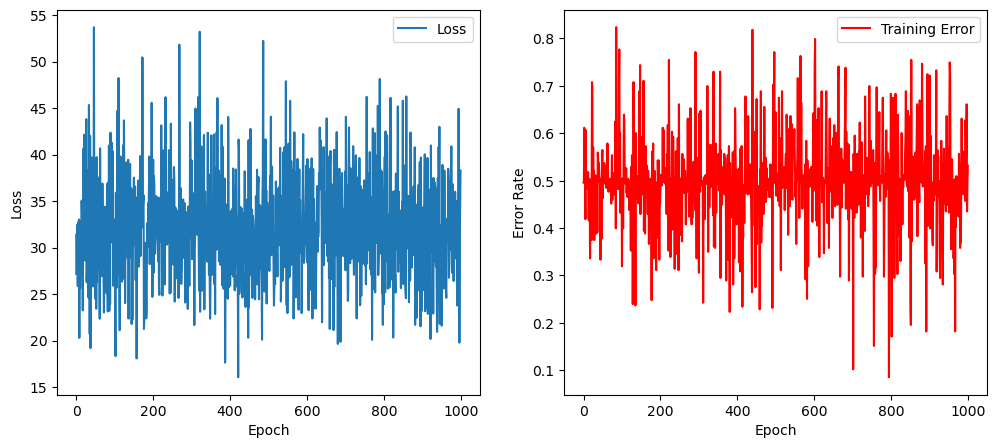

In [90]:
def train_and_visualize_svm(X, y):
    losses = []
    errors = []
    lambda_val = 0.01
    lr = 0.01
    epochs = 1000
    beta, b = np.zeros(X.shape[1]), 0

    for epoch in range(epochs):
        beta, b = fit_svm(X, y, lambda_val, lr, 1)  # Update for one epoch at a time
        pred = predict_svm(beta, b, X)
        error = np.mean(pred != y)
        margins = y * (np.dot(X, beta) + b)
        loss = 0.5 * np.dot(beta, beta) + (lambda_val / len(y)) * np.sum(relu(1 - margins))
        losses.append(loss)
        errors.append(error)

        if epoch % 100 == 0:
            lr /= 10  # Reduce learning rate

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(errors, label='Training Error', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate')
    plt.legend()

    plt.show()

# Example usage with your data
train_and_visualize_svm(data_filtered, target_filtered_adjusted)

In [48]:
def compare_svm_models(X, y):
    custom_svm = svm.SVC(kernel='linear')  # Using Scikit-learn's linear SVM for comparison
    lambda_vals = [0.001, 0.01, 0.1, 1.0]
    best_score = 0
    best_lambda = None

    for lambda_val in lambda_vals:
        model = CustomSVM(lambda_val=lambda_val)  
        score = np.mean(cross_val_score(model, X, y, cv=5))
        print(f"Lambda: {lambda_val}, Cross-Val Score: {score}")
        if score > best_score:
            best_score = score
            best_lambda = lambda_val

    print("Best Lambda:", best_lambda)
    print("Best Custom Cross-Validation Score:", best_score)

    # Compare with Scikit-learn SVM
    score_skl = np.mean(cross_val_score(custom_svm, X, y, cv=5))
    print("Scikit-learn SVM Score:", score_skl)

In [49]:
print("CV with full pixel vector")
compare_svm_models(data_filtered, target_filtered_adjusted)

CV with full pixel vector
Lambda: 0.001, Cross-Val Score: 0.4928843226788432
Lambda: 0.01, Cross-Val Score: 0.4768645357686453
Lambda: 0.1, Cross-Val Score: 0.5481354642313547
Lambda: 1.0, Cross-Val Score: 0.5839421613394216
Best Lambda: 1.0
Best Custom Cross-Validation Score: 0.5839421613394216
Scikit-learn SVM Score: 0.980745814307458


In [50]:
print("CV with 2d feature vector")
compare_svm_models(features2d(data_filtered), target_filtered_adjusted)

CV with 2d feature vector
Lambda: 0.001, Cross-Val Score: 0.5368340943683408
Lambda: 0.01, Cross-Val Score: 0.5123668188736682
Lambda: 0.1, Cross-Val Score: 0.5233257229832573
Lambda: 1.0, Cross-Val Score: 0.5861872146118722
Best Lambda: 1.0
Best Custom Cross-Validation Score: 0.5861872146118722
Scikit-learn SVM Score: 0.9282724505327244
